# 서울 부동산 시장 분석 및 투자 전략 수립

## 과제 3: 부동산 거래량과 가격의 선행지표 관계 분석
부동산 거래량 변화가 가격 변동에 미치는 영향을 시차 분석을 통해 파악하고, 시장 전환점을 예측할 수 있는 지표를 개발

- 월별 부동산 거래량 변화 확인
- 시장 전환점 예측(변곡점, 극대값, 극소값 등) 지표 개발

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약월'] = pd.to_datetime(df_sales['계약월'], format='%Y-%m-%d')

In [3]:
# 월별 계산
from da_utils.calc_monthly_annual import calc_monthly_annual
monthly_stats, _ = calc_monthly_annual(df_sales)

# 월별 거래량, 평단가 변화율 계산
monthly_stats['월별거래량변화율'] = monthly_stats['월별거래건수'].pct_change()
monthly_stats['월평균거래금액변화율'] = monthly_stats['월평균거래금액'].pct_change()
monthly_stats['월평균평단가변화율'] = monthly_stats['월평균평단가'].pct_change()

# display(monthly_stats)

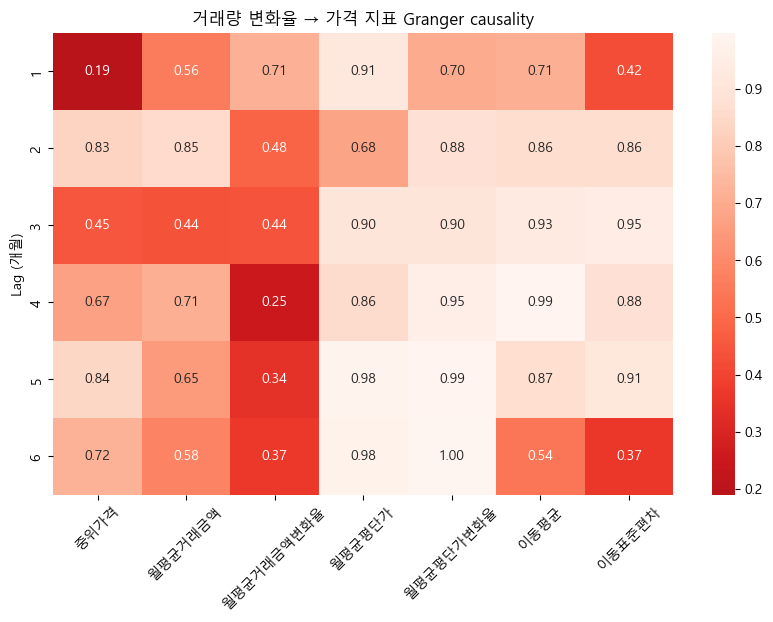

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests

# 분석할 컬럼
price_cols = ['중위가격', '월평균거래금액', '월평균거래금액변화율',
              '월평균평단가', '월평균평단가변화율', '이동평균', '이동표준편차']
volume_change_col = '월별거래량변화율'

max_lag = 6
pvalue_df = pd.DataFrame(index=range(1, max_lag+1), columns=price_cols)

# 시차별 Granger causality 테스트 (F-test p-value)
for col in price_cols:
    for lag in range(1, max_lag+1):  # 0 대신 1부터 시작
        # NaN 제거
        test_df = monthly_stats[[col, volume_change_col]].dropna()
        # Granger causality: X=거래량, Y=price_col
        if len(test_df) > lag + 1:  # 충분한 데이터 있는 경우만
            result = grangercausalitytests(test_df[[col, volume_change_col]], maxlag=lag, verbose=False)
            # lag번째 결과의 ssr F-test p-value 저장
            pvalue_df.loc[lag, col] = result[lag][0]['ssr_ftest'][1]
        else:
            pvalue_df.loc[lag, col] = np.nan

# 숫자형으로 변환
pvalue_df = pvalue_df.astype(float)
# display(pvalue_df)

# 시각화: p-value를 색으로 표현 (낮을수록 유의)
plt.figure(figsize=(10,6))
sns.heatmap(pvalue_df, annot=True, cmap='Reds_r', center=0.5, fmt=".2f")
plt.title('거래량 변화율 → 가격 지표 Granger causality')
plt.ylabel('Lag (개월)')
plt.xticks(rotation=45)

plt.show()


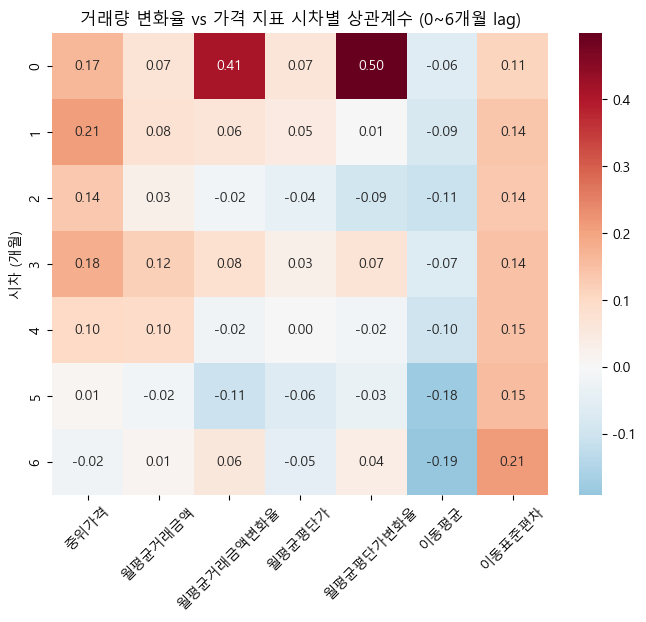

In [21]:
# 분석할 컬럼
price_cols = ['중위가격', '월평균거래금액', '월평균거래금액변화율', '월평균평단가', '월평균평단가변화율', '이동평균', '이동표준편차']
volume_change_col = '월별거래량변화율'

# 결과 저장용 데이터프레임
max_lag = 6
lag_range = range(0, max_lag+1)
corr_df = pd.DataFrame(index=lag_range, columns=price_cols)

# 시차별 상관계수 계산
for lag in lag_range:
    for col in price_cols:
        corr = monthly_stats[volume_change_col].shift(lag).corr(monthly_stats[col])
        corr_df.loc[lag, col] = corr

# 결과 확인
corr_df = corr_df.astype(float) 

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title(f'거래량 변화율 vs 가격 지표 시차별 상관계수 (0~{max_lag}개월 lag)')
plt.xticks(rotation=45)
plt.ylabel('시차 (개월)')
plt.savefig('./fig/03_leading_indicators/거래량시차별상관계수히트맵.png', dpi=300, bbox_inches='tight')
plt.show()

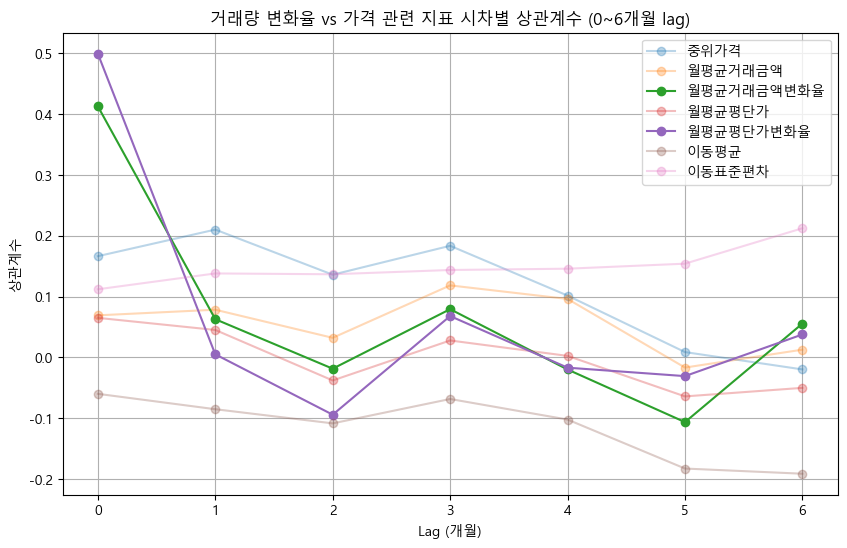

In [23]:
max_lag = 6
lag_corr_results = {}

for col in price_cols:
    lag_corr_results[col] = []
    for lag in range(0, max_lag+1):
        corr = monthly_stats[volume_change_col].shift(lag).corr(monthly_stats[col])
        lag_corr_results[col].append(corr)

# 라인차트 그리기
plt.figure(figsize=(10,6))

for col, values in lag_corr_results.items():
    # 절대값이 0.3 미만이면 투명도 낮추기
    alpha_val = 0.3 if max(abs(v) for v in values) < 0.3 else 1.0
    
    plt.plot(range(0, max_lag+1), values, marker='o', label=col, alpha=alpha_val)

plt.title(f'거래량 변화율 vs 가격 관련 지표 시차별 상관계수 (0~{max_lag}개월 lag)')
plt.xlabel('Lag (개월)')
plt.ylabel('상관계수')
plt.grid(True)
plt.legend()
plt.savefig('./fig/03_leading_indicators/거래량시차별상관계수라인차트.png', dpi=300, bbox_inches='tight')
plt.show()

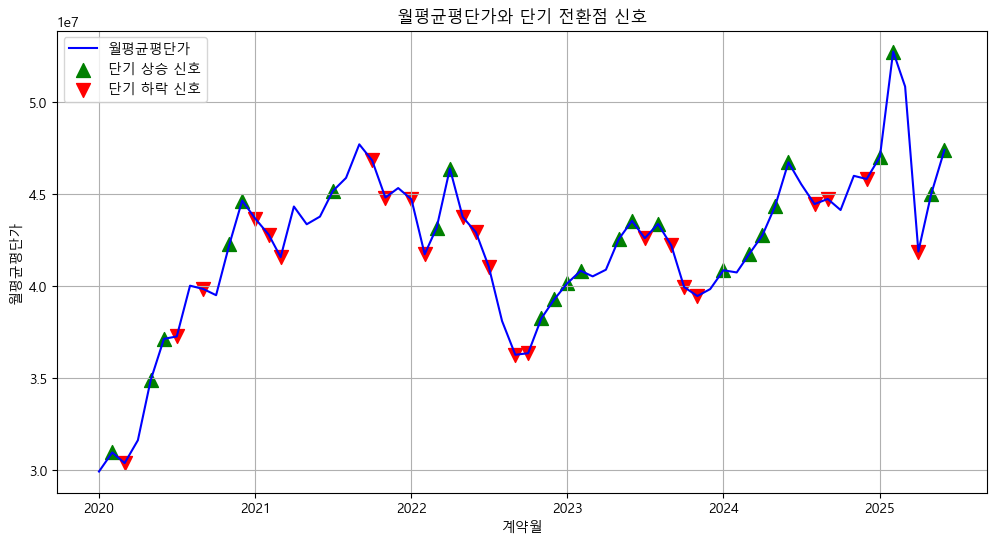

In [ ]:
# 비교 대상
search = '월평균평단가'

# 임계치 계산
threshold = 0.5
vol_thresh_up = monthly_stats['월별거래량변화율'].quantile(1- threshold)
vol_thresh_dn = monthly_stats['월별거래량변화율'].quantile(threshold)
price_thresh_up = monthly_stats[f'{search}변화율'].quantile(1- threshold)
price_thresh_dn = monthly_stats[f'{search}변화율'].quantile(threshold)


# 신호 생성
def signal(row):
    if (row['월별거래량변화율'] > vol_thresh_up) and (row[f'{search}변화율'] > price_thresh_up):
        return 1  # 단기 상승 신호
    elif (row['월별거래량변화율'] < vol_thresh_dn) and (row[f'{search}변화율'] < price_thresh_dn):
        return -1  # 단기 하락 신호
    else:
        return 0  # 신호 없음

monthly_stats['단기전환점신호'] = monthly_stats.apply(signal, axis=1)

plt.figure(figsize=(12,6))
plt.plot(monthly_stats['계약월'], monthly_stats[search], label=search, color='blue')

# 상승 신호 표시
plt.scatter(monthly_stats.loc[monthly_stats['단기전환점신호']==1, '계약월'],
            monthly_stats.loc[monthly_stats['단기전환점신호']==1, search],
            color='green', marker='^', label='단기 상승 신호', s=100)

# 하락 신호 표시
plt.scatter(monthly_stats.loc[monthly_stats['단기전환점신호']==-1, '계약월'],
            monthly_stats.loc[monthly_stats['단기전환점신호']==-1, search],
            color='red', marker='v', label='단기 하락 신호', s=100)

plt.title(f'{search}와 단기 전환점 신호')
plt.xlabel('계약월')
plt.ylabel(search)
plt.legend()
plt.grid(True)
plt.savefig('./fig/03_leading_indicators/단기전환점적용후그래프.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 다음 달 가격 변화율 계산
monthly_stats['다음달변화'] = monthly_stats[search].shift(-1) - monthly_stats[search]

# 실제 상승/하락 라벨
monthly_stats['실제변곡점'] = monthly_stats['다음달변화'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))

# 신호와 실제 변곡점 비교
y_true = monthly_stats['실제변곡점']
y_pred = monthly_stats['단기전환점신호']

# 상승 신호 평가
precision_up = precision_score(y_true, y_pred, labels=[1], average='macro')
recall_up = recall_score(y_true, y_pred, labels=[1], average='macro')
f1_up = f1_score(y_true, y_pred, labels=[1], average='macro')

# 하락 신호 평가
precision_dn = precision_score(y_true, y_pred, labels=[-1], average='macro')
recall_dn = recall_score(y_true, y_pred, labels=[-1], average='macro')
f1_dn = f1_score(y_true, y_pred, labels=[-1], average='macro')

# 결과 출력
performance = pd.DataFrame({
    'threshold':threshold,
    'precision_up':[precision_up],
    'recall_up':[recall_up],
    'f1_up':[f1_up],
    'precision_dn':[precision_dn],
    'recall_dn':[recall_dn],
    'f1_dn':[f1_dn]
})

performance = performance.round(3)
display(performance)
performance.to_csv('./data/03_leading_indicators/전환점평가결과.csv')

,threshold,precision_up,recall_up,f1_up,precision_dn,recall_dn,f1_dn
0,0.5,0.583,0.378,0.459,0.478,0.393,0.431
